## Loading Images Using tf.Data.Dataset

#### Learning Objectives

1. Retrieve Images using tf.keras.utils.get_file
2. Load Images using Keras Pre-processing
3. Load Images using tf.Data.Dataset
4. Understand Basic Methods for Training

#### Introduction

Load images using tf.Data. The dataset example consists of directories of images where each directory refers to one class.

#### Load Necessary Libraries

In [3]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
print ("Tensorflow version: ", tf.version.VERSION)

Tensorflow version:  2.5.0


In [12]:
#Autotune - Convert a number or string to an integer, or return 0 if no arguments are given.
AUTOTUNE = tf.data.experimental.AUTOTUNE

#### Retrieve Images using tf.keras.utils.get_file

Images include archive of creative-commons licensed flower photos from Google

In [14]:
import pathlib
data_dir = tf.keras.utils.get_file(origin = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                  fname = 'flower_photos', untar =True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 1s 0us/step


The directory contains 5 directories, one per class.

In [22]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

In [26]:
#each directory contains the type of flower
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != 'LICENSE.txt'])
CLASS_NAMES

array(['tulips', 'sunflowers', 'roses', 'dandelion', 'daisy'],
      dtype='<U10')

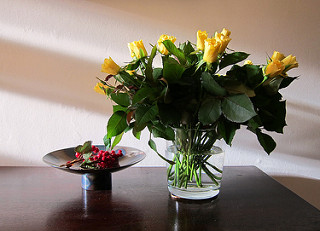

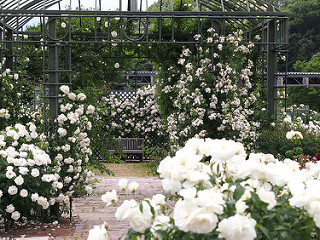

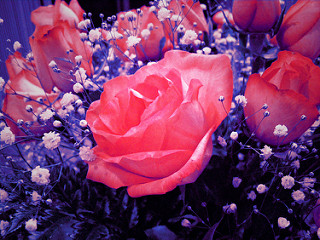

In [30]:
roses = list(data_dir.glob('roses/*'))

for image_path in roses[:3]:
    display.display(Image.open(str(image_path)))

#### Load data Using keras.preprocessing

A simple way to load images is to use tf.keras.preprocessing.

In [100]:
#Load images using tf.keras.preprocessing
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

In [101]:
#Define some parameters for the loader
BATCH_SIZE = 32
IMG_HEIGHT =224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [102]:
train_data_gen = image_generator.flow_from_directory(directory = str(data_dir),
                                                     batch_size = BATCH_SIZE,
                                                     shuffle = True,
                                                     target_size = (IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 3670 images belonging to 5 classes.


In [103]:
# Here, define show_batch() procedure for Inspecting a batch.
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1) # TODO 1b
      plt.imshow(image_batch[n]) # TODO 1b
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

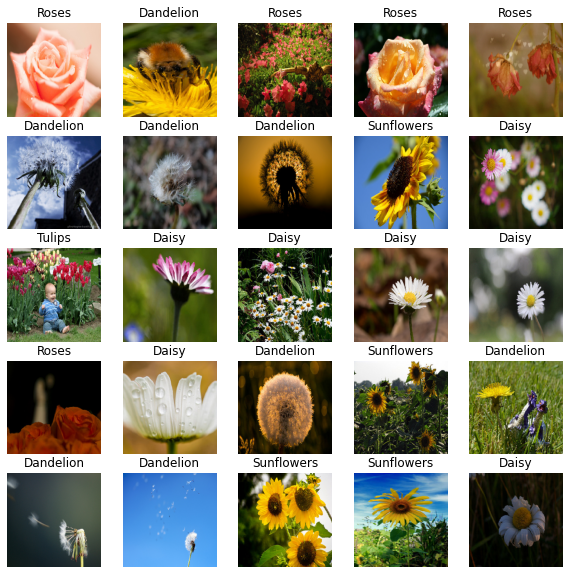

In [104]:
# Here, next() function returns the next item in an iterator.
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

#### Load Images using tf.Data.Dataset

keras.preprocessing method is convienient in loading images but has three downsides. This includes the following:

1. It's slow.
2. Lacks fine-grained control
3. It is not well-integrated with the rest of the Tensorflow.

Let us try to load the images using tf.Data.Dataset by creating first a dataset of **file paths**.

In [105]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

In [106]:
# Here, .take() method return elements from array along the mentioned axis and indices.
for f in list_ds.take(5):
  print(f.numpy())

b'/home/jupyter/.keras/datasets/flower_photos/tulips/4497976955_3f8c2a21c1_m.jpg'
b'/home/jupyter/.keras/datasets/flower_photos/tulips/17994129033_bbd0acba62_n.jpg'
b'/home/jupyter/.keras/datasets/flower_photos/sunflowers/3951246342_930138610b_n.jpg'
b'/home/jupyter/.keras/datasets/flower_photos/sunflowers/4933821940_38064522a8.jpg'
b'/home/jupyter/.keras/datasets/flower_photos/dandelion/2503034372_db7867de51_m.jpg'


In [107]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep) 
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES 

In [108]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3) 
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32) 
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [109]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path) 
  img = decode_img(img)
  return img, label

Use Dataset.map to create a dataset of images and label pairs

In [110]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [111]:
# Print the value of `Image shape` and `Label`
for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [False  True False False False]


#### Basic Methods for Training

To train a model using this dataset, you will want the data:

- to be well-shuffled
- to be batched
- batches to be available as soon as possible

These features can be easily added using the tf.Data api

In [112]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size) # TODO 3a

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [113]:
# Here, the next() function returns the next item in an iterator.
train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds))

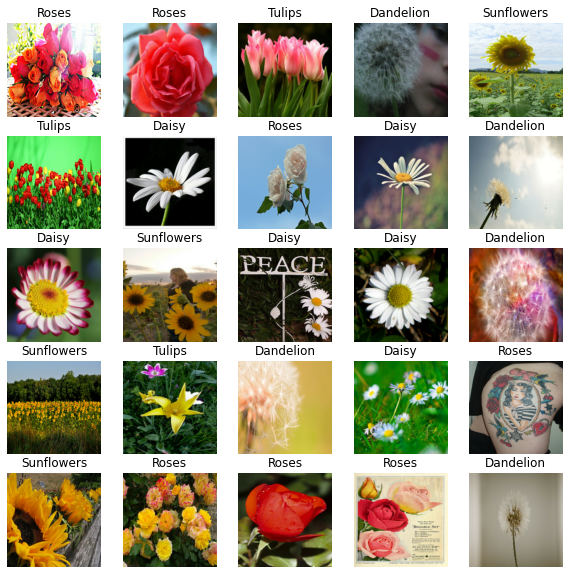

In [114]:
# Here, we define show_batch() procedure for Inspecting a batch
show_batch(image_batch.numpy(), label_batch.numpy())